# Setup

In [1]:
import shutil

from matplotlib_scalebar.scalebar import ScaleBar
import contextily as ctx

from utils import *

# Prepare data

## Accessibility by mode & purpose

Copy the processed data of BG geometries, opportunities distribution, and interzonal deterrence data from the accessibility project folder.

In [2]:
msa_names = ('San Francisco', 'Atlanta', 'Indianapolis')
msa_keys = tuple([x.replace(' ', '-').lower() for x in msa_names])

In [3]:
inroot = Path('../../spr_4711/data')
outroot = mkdir('../data/access')

### Block groups

In [4]:
zones = gpd.read_parquet(outroot / 'zones.parquet').set_crs(CRS_M).disp()

8,514 rows x 4 cols; Memory: 1.2 MiB; CRS: EPSG:3857


,region,geoid,geometry,popu
,<object>,<object>,<geometry>,<float64>
0,san-francisco,060014001001,"POLYGON ((-13608463.772251 4563242.954634, -13...",1963.0


### Opportunities

In [5]:
opp = pd.read_parquet(inroot / 'opportunities.parquet')
opp['purpose'] = opp.kind.map(D(
    total='Work', shopping='Shopping', leisure='Social'))
opp = opp[['geoid', 'purpose', 'opport']]
opp = opp.dropna().merge(zones['geoid']).disp()
opp.to_parquet(outroot / 'opportunities.parquet')

18,264 rows x 3 cols; Memory: 2.4 MiB


,geoid,purpose,opport
,<object>,<object>,<int32>
0,060014001001,Work,324


### Distances

In [6]:
for msa, mode in it.product(msa_keys, ['drive', 'walk']):
    path = inroot / f'osrm/msa/{msa}/bg_{mode}_2020.parquet'
    shutil.copy(path, mkfile(outroot / f'dist/{msa}_{mode}.parquet'))

## Urbanity

In [7]:
# # t=0:09
# urb = (
#     pd.read_csv('https://www2.census.gov/geo/docs/reference/ua/2020_UA_BLOCKS.txt',
#                 sep='|', encoding='unicode_escape')
#     .rename(columns=lambda x: x.lower().lstrip('2020_'))
#     .rename(columns=D(arealand='aland', hou='houses', pop='popu', uace='ua_code'))
#     .drop(columns=['state', 'county', 'tract', 'block'])
#     .assign(geoid=lambda df: df.geoid.astype(str).str.zfill(15).str[:12])
#     .groupby(['geoid', 'ua_code', 'ua_name'])
#     [['aland', 'houses', 'popu']].sum().reset_index()
#     .merge(zones['geoid'])
#     .astype(D(ua_code=CAT, ua_name=CAT, aland=np.int32, houses=np.int32, popu=np.int32))
# ).disp()
# urb.to_parquet(outroot / 'urban_area_bgs.parquet')

In [8]:
urb = pd.read_parquet(outroot / 'urban_area_bgs.parquet').disp()

8,107 rows x 6 cols; Memory: 0.7 MiB


,geoid,ua_code,ua_name,aland,houses,popu
,<object>,<int64>,<category>,<int32>,<int32>,<int32>
0,060014001001,78904,"San Francisco--Oakland, CA",3495109,784,1789


## Compute accessibility

### At BG level

In [9]:
def get_access_bg(overwrite=False):
    outpath = Path('../data/access/access_comparison_time.parquet')
    if outpath.exists() and not overwrite:
        return pd.read_parquet(outpath)
    coef = (pd.read_parquet('../data/decay_func_fit.parquet').query(
        'Target=="Duration" & Func=="Base exponential" & '
        'StayTime{0} & MSAKind{0} & FlowType{0}'.format('=="Overall"'))
            .explode('Params').rename(columns=D(Params='Beta')))
    beta0 = coef.query('Mode=="Overall" & Purpose=="Overall"').iloc[0].Beta
    coef = coef[(coef.Mode.isin(['Drive', 'Walk'])) & 
                (coef.Purpose.isin(['Work', 'Social', 'Shopping']))
               ][['Mode', 'Purpose', 'Beta']]
    zones = pd.read_parquet('../data/access/zones.parquet')
    opp = pd.read_parquet('../data/access/opportunities.parquet')
    opp = opp.merge(zones[['region', 'geoid']])
    res = []
    pbar = tqdm(list(it.product(opp.region.unique(), coef.Mode.unique())))
    for rgn, mode in pbar:
        msa = rgn.replace('-', ' ').title()
        pbar.set_description(f'{msa} → {mode}')
        fpath = f'../data/access/dist/{rgn}_{mode.lower()}.parquet'
        dist = pd.read_parquet(fpath).rename(
            columns=D(src_geoid='geoid', trg_geoid='trg'))
        dist.duration /= 60 # s to min
        for purpose in coef.Purpose.unique():
            df = opp.query(f'region=="{rgn}" & purpose=="{purpose}"')
            df = dist.merge(df.rename(columns=D(geoid='trg')))
            df = df[['geoid', 'duration', 'opport']]
            beta = (coef.query(f'Mode=="{mode}" & Purpose=="{purpose}"')
                    .iloc[0].Beta)
            for thresh in tqdm(np.arange(5, 90 + 1, 5), leave=False):
                d = df[df.duration <= thresh].reset_index(drop=1)
                d['general'] = d.opport * np.exp(d.duration * beta0)
                d['correct'] = d.opport * np.exp(d.duration * beta)
                d = d.merge(zones[['geoid', 'popu']])
                d = (d.groupby('geoid')[['popu', 'general', 'correct']]
                     .sum().astype(np.float32).reset_index())
                d['pct_diff'] = (d.correct / (d.general + 1e-6) - 1) * 100
                res.append(d.assign(
                    msa=msa, mode=mode, purpose=purpose, thresh=thresh))
    res = pd.concat(res).astype(D(
        geoid=CAT, msa=CAT, mode=CAT, purpose=CAT, thresh=CAT))
    res.to_parquet(mkfile(outpath))
    return res

xs_bg = get_access_bg(overwrite=0).disp() # t=2:49
# %time x = get_access_bg(overwrite=1); x

878,658 rows x 9 cols; Memory: 31.8 MiB


,geoid,popu,general,correct,msa,mode,purpose,thresh,pct_diff
,<category>,<float32>,<float32>,<float32>,<category>,<category>,<category>,<int64>,<float32>
0,060014001001,9815.0,1118.199829,1160.642822,San Francisco,Drive,Work,5,3.79566


### At MSA level

In [10]:
def get_access_msa(xs=xs_bg):
    res = []
    for comb, df in xs.groupby(['msa', 'mode', 'purpose', 'thresh']):
        correct = (df.correct * df.popu).sum() / df.popu.sum()
        general = (df.general * df.popu).sum() / df.popu.sum()
        pct_diff = (correct / general - 1) * 100
        comb = D(zip('msa mode purpose thresh'.split(), comb))
        res.append(comb | D(pct_diff=pct_diff))
    res = Pdf(res)
    return res

xs_diff_msa = get_access_msa().disp()

324 rows x 5 cols; Memory: 0.1 MiB


,msa,mode,purpose,thresh,pct_diff
,<object>,<object>,<object>,<int64>,<float64>
0,Atlanta,Drive,Shopping,5,-4.351526


  0%|          | 0/3 [00:00<?, ?it/s]

CPU times: user 12.4 s, sys: 976 ms, total: 13.4 s
Wall time: 15.4 s


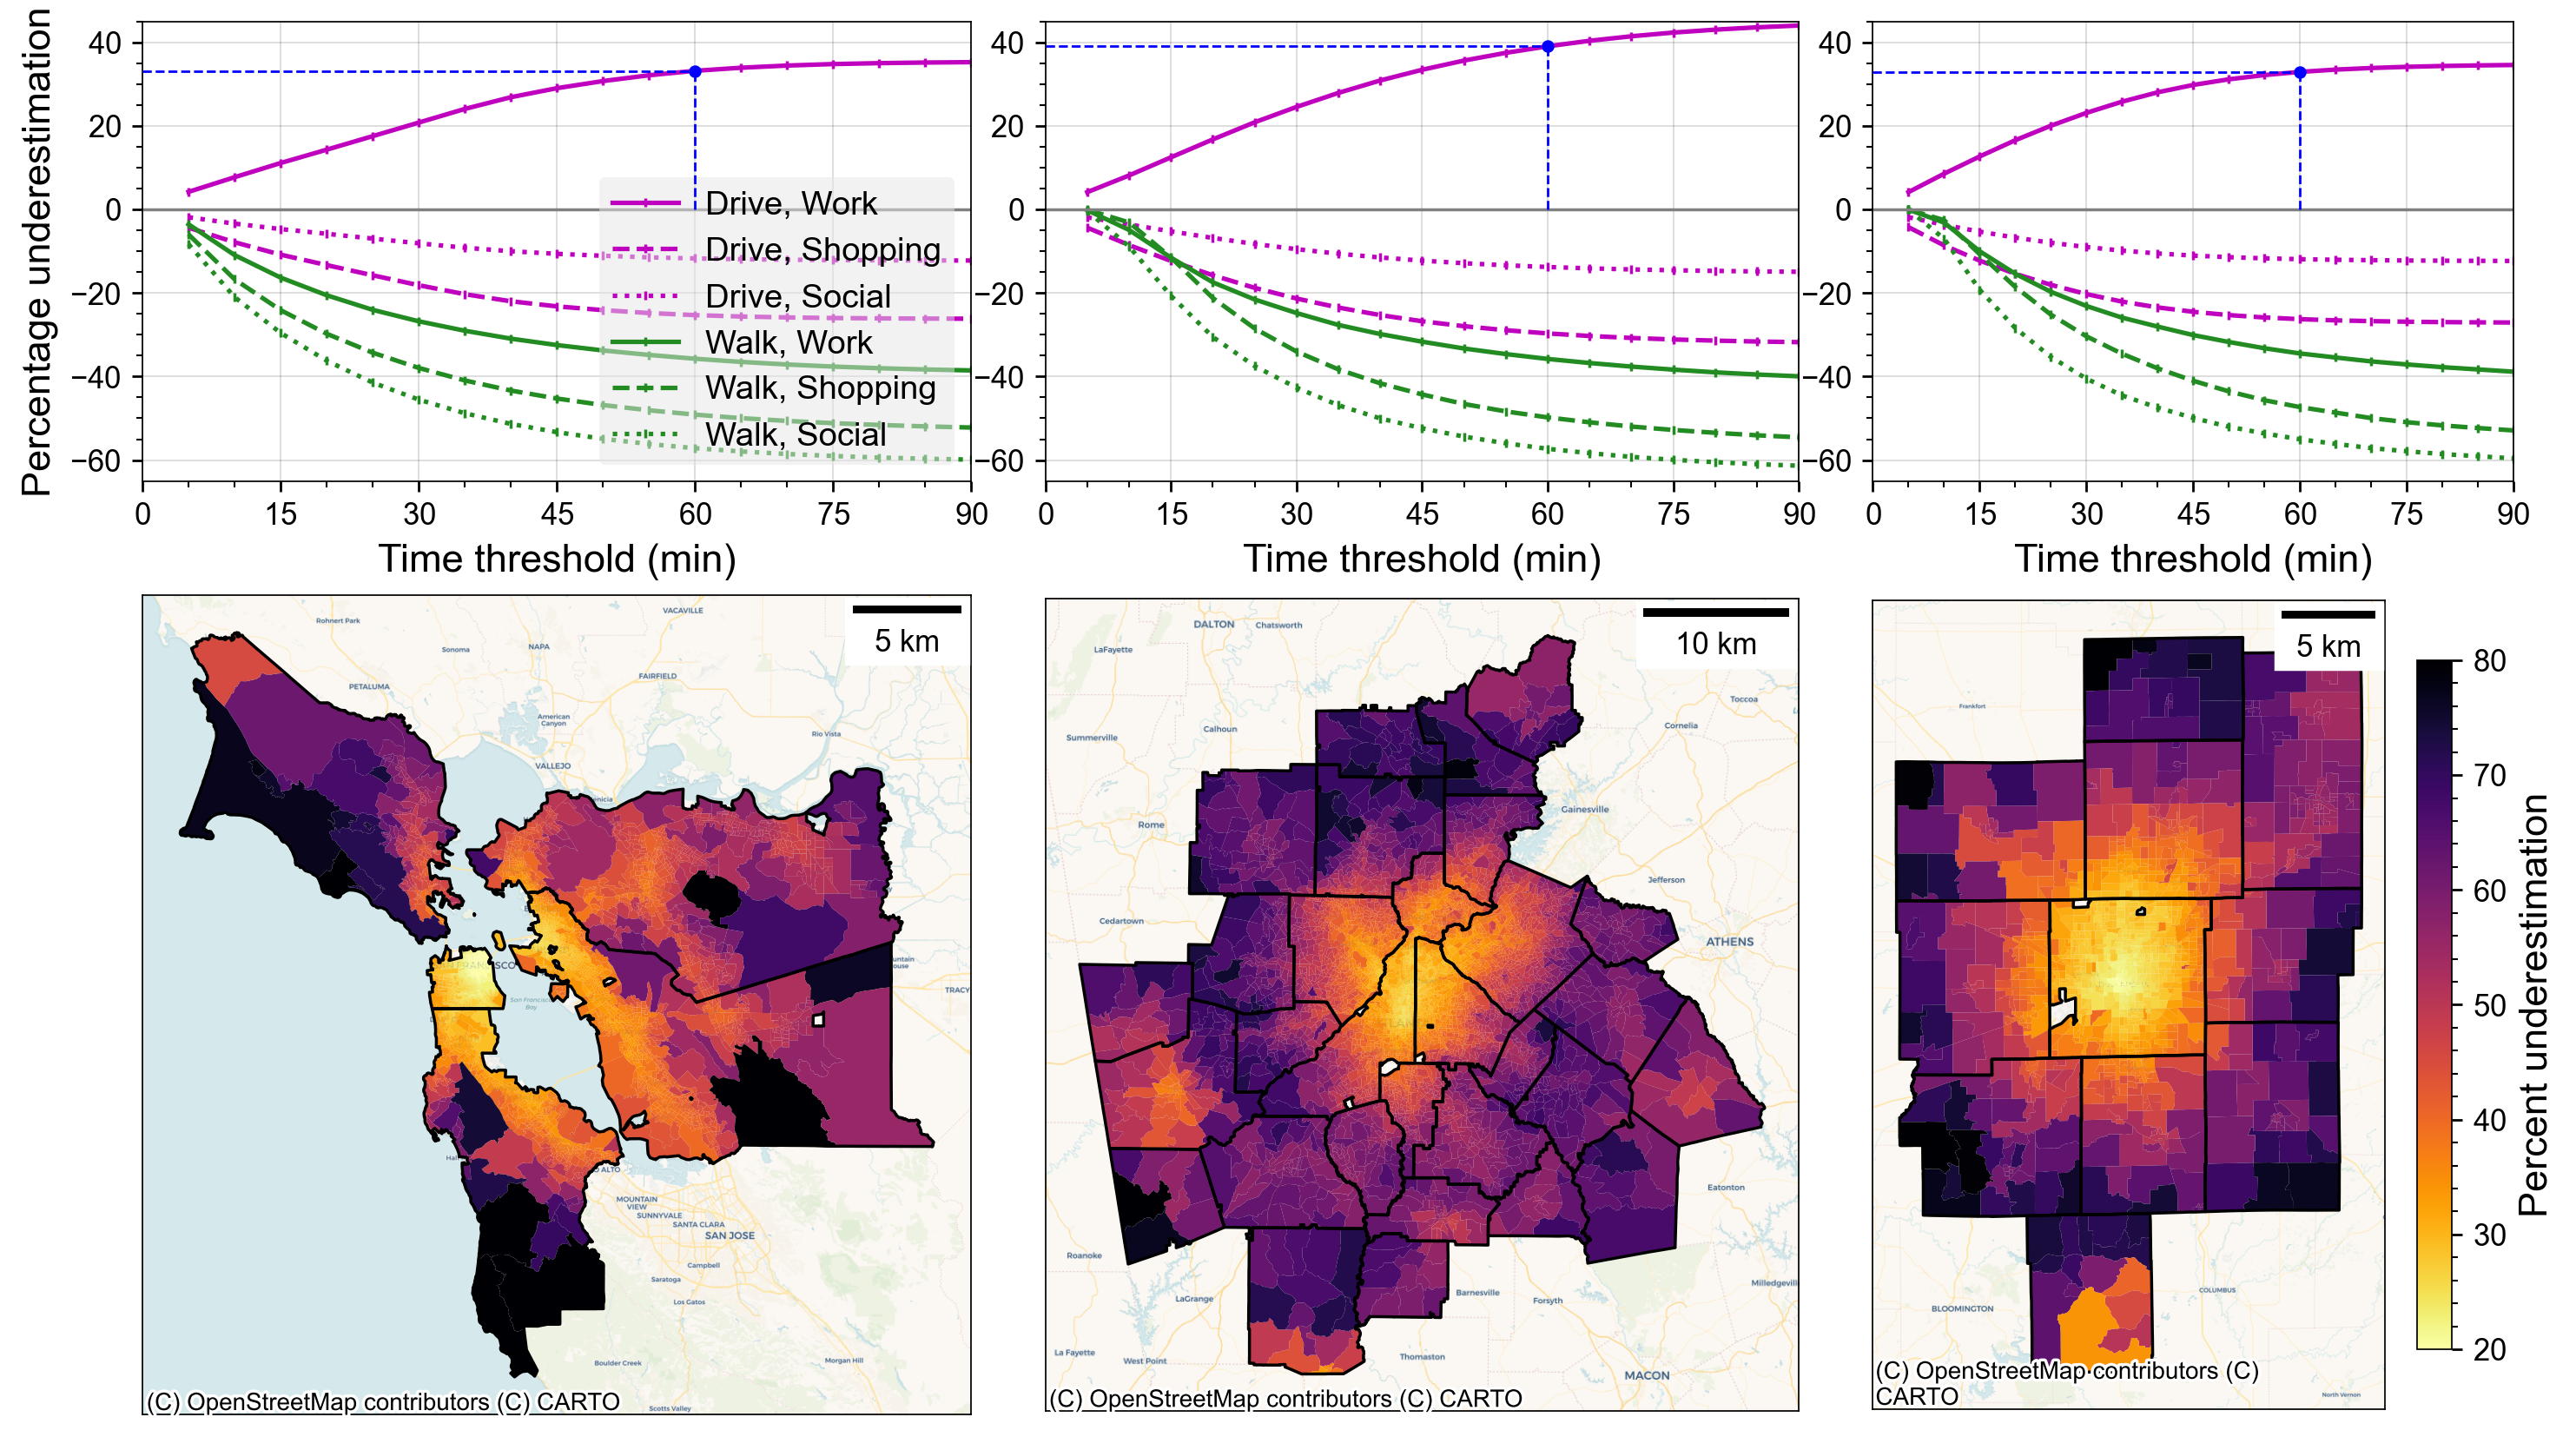

In [11]:
def fig_access_comparison(xs_bg=xs_bg, xs_msa=xs_diff_msa, dpi=150):
    _, axes = plt.subplots(2, 3, figsize=(12, 8), dpi=dpi,
                           gridspec_kw=D(width_ratios=[1.1, 1, 0.85],
                                         height_ratios=[2, 6]))
    mode_colors = D(Drive='m', Walk='forestgreen')
    purp_ls = D(Work='-', Shopping='--', Social=':')
    basemap = ctx.providers.CartoDB.Voyager
    xs = xs_bg.query('mode=="Drive" & purpose=="Work" & thresh==60')
    zones = gpd.read_parquet('../data/access/zones.parquet')
    msas = ('San Francisco', 'Atlanta', 'Indianapolis')
    for j, msa in enumerate(tqdm(msas)):
        ## Top row: Percent change by threshold
        ax = pplot(axes[0, j], xlab='Time threshold (min)',
                   ylim=(-65, 45), xlim=(0, 90))
        df = xs_msa.query(f'msa=="{msa}"')
        for mode, color in mode_colors.items():
            df2 = df[df['mode'] == mode]
            for purpose, ls in purp_ls.items():
                d = df2.query(f'purpose=="{purpose}"')
                ax.plot(d.thresh, d.pct_diff, '|' + ls, lw=1.5,
                        markersize=3, color=color,
                        label=f'{mode}, {purpose}')
                if mode == 'Drive' and purpose == 'Work':
                    y = d.set_index('thresh').loc[60].pct_diff
                    ax.scatter(60, y, marker='o', s=10, color='b', zorder=10)
                    ax.plot([0, 60], [y] * 2, 'b--', lw=0.8, zorder=10)
                    ax.plot([60] * 2, [0, y], 'b--', lw=0.8, zorder=10)
        ax.axhline(0, color='grey', lw=1)
        ax.set_xticks(np.arange(0, 91, 15))
        ax.xaxis.set_minor_locator(mpl.ticker.MultipleLocator(5))
        if j == 0: ax.set_ylabel('Percentage underestimation')
        if j == 0: ax.legend(loc='lower right')
        ## Bottom row: Map
        df = zones[zones.region == msa.replace(' ', '-').lower()]
        df = df[['geoid', 'geometry']].merge(xs)
        cnty = df.assign(geoid=df.geoid.str[:5])[
            ['geoid', 'geometry']].dissolve('geoid')
        ax = pplot(axes[1, j])
        df.plot(ax=ax, column='pct_diff', cmap='inferno_r', vmin=20, vmax=80,
                legend=j == 2, legend_kwds=D(
                    shrink=0.5, label='Percent underestimation'))
        cnty.plot(ax=ax, ec='k', lw=1, fc='none')
        ctx.add_basemap(ax=ax, crs=CRS_M, source=basemap)
        ax.add_artist(ScaleBar(0.2))
        ax.tick_params(axis='both', which='both', left=0, bottom=0)
        ax.set_xticks([]); ax.set_yticks([])
    plt.tight_layout()
    plt.subplots_adjust(wspace=0.1, hspace=-0.18)

x = fig_access_comparison(dpi=250); x # t=0:15